# Taper Transition Analysis

In [1]:
import os, math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [19]:
TABLES_DIRECTORY = "../../Data/giant_tables"
SYNCHRONY_ENTROPY_DIRECTORY = "../../Data/plv/kuramoto/delta_entropy"
TAPER_THRESHOLD = 0.5

In [3]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = int(filename.split("_")[1].split(".")[0])
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

62

## Plotting function

In [4]:
def plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(13, 1, figsize=(10, 20), sharex=True)

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(
                hourly_patient_features_df["emu_hour"], normalized_data, label=label
            )

    # Adding horizontal bars
    ax[0].hlines(
        1, before_taper_period[0], before_taper_period[1], color="green", linewidth=2
    )
    ax[0].hlines(
        1, after_taper_period[0], after_taper_period[1], color="red", linewidth=2
    )

    # Adding text annotations
    ax[0].text(
        (before_taper_period[0] + before_taper_period[1]) / 2,
        1,
        "before taper",
        ha="center",
        va="bottom",
    )
    ax[0].text(
        (after_taper_period[0] + after_taper_period[1]) / 2,
        1,
        "after taper",
        ha="center",
        va="bottom",
    )

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Normalized Load")
    ax[0].set_ylim([0, 1.3])
    ax[0].legend(loc="upper right")
    ax[0].set_title("Individual AEDs")

    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")

    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_all"],
    )
    for idx in seizure_hours:
        ax[2].axvline(x=idx, color="red", linestyle="dotted")

    ax[2].set_ylabel("Total Spikes")
    ax[2].set_title("All Spikes")

    # Plotting Teager energy for all frequency bands
    bands = ["delta", "theta", "alpha", "beta", "gamma"]
    for i, band in enumerate(bands):
        ax[i + 3].plot(
            hourly_patient_features_df["emu_hour"],
            hourly_patient_features_df["teager_energy_" + band],
        )
        for idx in seizure_hours:
            ax[i + 3].axvline(x=idx, color="red", linestyle="dotted")

        ax[i + 3].set_ylabel("Teager Energy")
        ax[i + 3].set_title(f"Teager Energy ({band.capitalize()} Band)")

    # Plotting Kuramoto for all frequency bands
    for i, band in enumerate(bands):
        ax[i + 8].plot(
            hourly_patient_features_df["emu_hour"],
            hourly_patient_features_df["kuramoto_" + band],
        )
        for idx in seizure_hours:
            ax[i + 8].axvline(x=idx, color="red", linestyle="dotted")

        ax[i + 8].set_ylabel("R")
        ax[i + 8].set_title(f"Synchrony ({band.capitalize()} Band)")

    ax[12].set_xlabel("Time (hours)")

    plt.tight_layout()
    plt.show()

## Find taper period function

In [5]:
def find_taper_periods(hourly_patient_features_df, patient_hup_id):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[
        (~hourly_patient_features_df["teager_energy_delta"].isna())
        & (~hourly_patient_features_df["kuramoto_delta"].isna())
    ].emu_hour.min()

    # Get medication columns
    med_columns = [
        col for col in hourly_patient_features_df.columns if col.startswith("med_")
    ]

    # 2 day periods with 3 day gap
    before_taper_period = (start_point, start_point + 48)
    after_taper_period = (start_point + 48 + 72, start_point + 48 + 72 + 48)
    period_length_days = 2
    gap_length_days = 3

    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 3 day gap contains seizures")
        # 2 day periods with 2 day gap
        before_taper_period = (start_point, start_point + 48)
        after_taper_period = (start_point + 48 + 48, start_point + 48 + 48 + 48)
        period_length_days = 2
        gap_length_days = 2

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 2 day gap contains seizures")
        # 2 day periods with 1 day gap
        before_taper_period = (start_point, start_point + 48)
        after_taper_period = (start_point + 48 + 24, start_point + 48 + 24 + 48)
        period_length_days, gap_length_days = 2, 1

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("2 day periods with 1 day gap contains seizures")
        # 1 day periods with 2 day gap
        before_taper_period = (start_point, start_point + 24)
        after_taper_period = (start_point + 24 + 48, start_point + 24 + 48 + 24)
        period_length_days = 1
        gap_length_days = 1

    # check if after_taper_period contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("1 day periods with 2 day gap contains seizures")
        # 1 day periods with 1 day gap
        before_taper_period = (start_point, start_point + 24)
        after_taper_period = (start_point + 24 + 24, start_point + 24 + 24 + 24)
        period_length_days = 1
        gap_length_days = 1

    # check if the entire two periods contains seizures
    if (
        hourly_patient_features_df[
            (hourly_patient_features_df["num_seizures"] > 0)
            & (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1])
        ].shape[0]
        > 0
    ):
        print("1 day periods with 1 day gap contains seizures")
        print("Last straw, both periods contain seizures, discard!")
        return (np.nan, np.nan), (np.nan, np.nan), None, None

    return before_taper_period, after_taper_period, period_length_days, gap_length_days

## Plot all time series

In [6]:
good_hup_ids = []

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    (
        before_taper_period,
        after_taper_period,
        period_length_days,
        gap_length_days,
    ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    print(
        f"Patient {patient_hup_id} before taper period: {before_taper_period} after taper period: {after_taper_period}"
    )
    good_hup_ids.append(patient_hup_id)

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
1 day periods with 1 day gap contains seizures
Last straw, both periods contain seizures, discard!
Patient 138 has nan values in before_taper_period or after_taper_period
1 day periods with 1 day gap contains seizures
Last straw, both periods contain seizures, discard!
Patient 140 has nan values in before_taper_period or after_taper_period
1 day periods with 1 day gap contains seizures
Last straw, both periods contain seizures, discard!
Patient 141 has nan values in before_taper_period or after_taper_period
1 day periods with 1 day gap contains seizures
Last straw, both periods contain seizures, discard!
Patient 142 has nan values in before_taper_period or after_taper_period
2 day periods with 3 day gap contains seizures
Patient 143 before taper period: (42, 90) after taper period: (138, 186)
1 day pe

In [7]:
len(good_hup_ids)

24

2 day periods with 3 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods with 3 day gap contains seizures
2 day periods

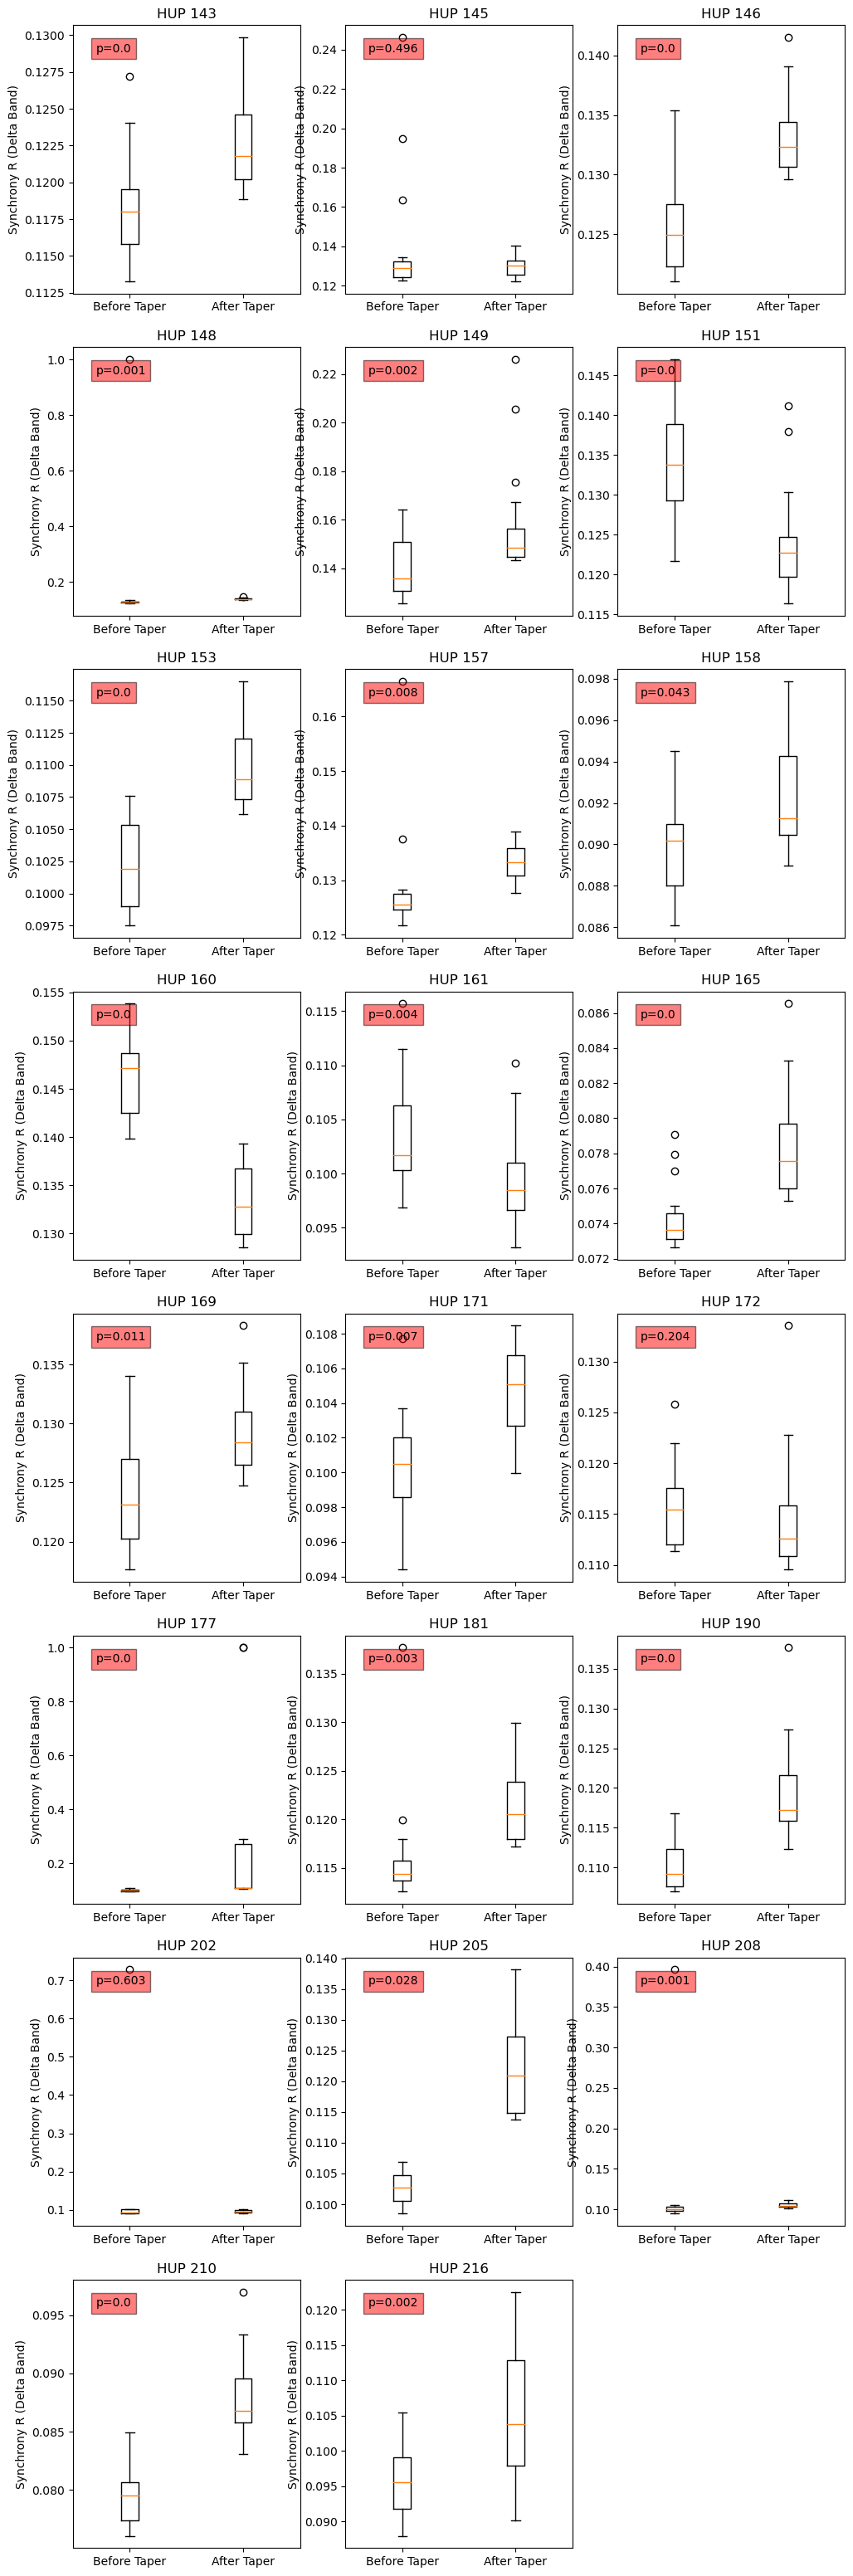

In [8]:
synchrony_good_hup_ids = []
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 3)

# The frequency bands we're considering
freq_bands = ["delta"]

for band in freq_bands:
    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, 3, figsize=(12, num_rows * 5))

    # Initialize counters
    count = 0
    match_expectation_counter = 0

    for patient_hup_id in good_hup_ids:
        # Read in the giant table for this patient
        hourly_patient_features_df = pd.read_csv(
            os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
        )
        (
            before_taper_period,
            after_taper_period,
            period_length_days,
            gap_length_days,
        ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

        # If any value in before_taper_period or after_taper_period is nan, skip this patient
        if (
            np.isnan(before_taper_period[0])
            or np.isnan(before_taper_period[1])
            or np.isnan(after_taper_period[0])
            or np.isnan(after_taper_period[1])
        ):
            print(
                f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
            )
            continue

        # Get the 'emu_hour' and 'teager_energy_{band}' rows within the before and after taper periods
        before_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
            f"kuramoto_{band}",
        ]
        after_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
            f"kuramoto_{band}",
        ]

        # Assert the length of before and after taper periods are both a multiple of 24
        assert len(before_taper) % 24 == 0
        assert len(after_taper) % 24 == 0

        # Remove nan values
        before_taper = before_taper.dropna()
        after_taper = after_taper.dropna()

        # # Drop the first two elements of before_taper
        # before_taper = before_taper.iloc[2:]
        # Drop the lowest half of values in before_taper
        before_taper = before_taper.sort_values().iloc[len(before_taper) // 2 :]
        # Drop the lowest half of values in after_taper
        after_taper = after_taper.sort_values().iloc[len(after_taper) // 2 :]

        if len(before_taper) == 0 or len(after_taper) == 0:
            print(
                f"Patient {patient_hup_id} has no values in before_taper or after_taper"
            )
            continue

        # Create box plots
        row = count // 3
        col = count % 3
        axs[row, col].boxplot(
            [before_taper, after_taper], labels=["Before Taper", "After Taper"]
        )

        axs[row, col].set_title(f"HUP {patient_hup_id}")
        # Set y-axis label
        axs[row, col].set_ylabel(f"Synchrony R ({band.capitalize()} Band)")

        # Wilcoxon rank-sum test
        w_stat, w_p = stats.ranksums(before_taper, after_taper)
        w_p = round(w_p, 3)
        w_stat = round(w_stat, 3)

        # Kolmogorov-Smirnov test
        ks_stat, ks_p = stats.ks_2samp(before_taper, after_taper)
        ks_p = round(ks_p, 3)
        ks_stat = round(ks_stat, 3)

        # Check if the mean of before_taper is larger than the mean of after_taper
        if after_taper.mean() > before_taper.mean() and w_p < 0.05:
            synchrony_good_hup_ids.append(patient_hup_id)
            match_expectation_counter += 1

        # Add test statistics to subplot
        axs[row, col].text(
            0.1,
            0.9,
            f"p={w_p}",
            transform=axs[row, col].transAxes,
            bbox=dict(facecolor="red", alpha=0.5),
        )

        count += 1

    # Remove unused subplots
    for i in range(count, num_rows * 3):
        fig.delaxes(axs.flatten()[i])

    # # Adjust spacing
    # plt.tight_layout()

    # # Show the plot
    # plt.show()

    # Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
    print(
        f"The mean of after_taper is bigger than the mean of before_taper for {match_expectation_counter} out of {count} patients in {band.capitalize()} band."
    )

In [9]:
synchrony_good_hup_ids

[143, 146, 149, 153, 157, 158, 165, 169, 171, 177, 181, 190, 205, 210, 216]

In [21]:
# Load ./data/ieeg_starts.xlsx into a dataframe
ieeg_starts_df = pd.read_excel("../../Data/ieeg_starts.xlsx")
ieeg_starts_df

,hup_id,ieeg_start
0,225,38.024167
1,224,37.582778
2,223,32.985556
3,221,37.690000
4,219,33.396667
...,...,...
75,141,37.249444
76,140,35.197500
77,139,37.151667
78,138,37.529444


# Plot synchrony across transition period

2 day periods with 3 day gap contains seizures


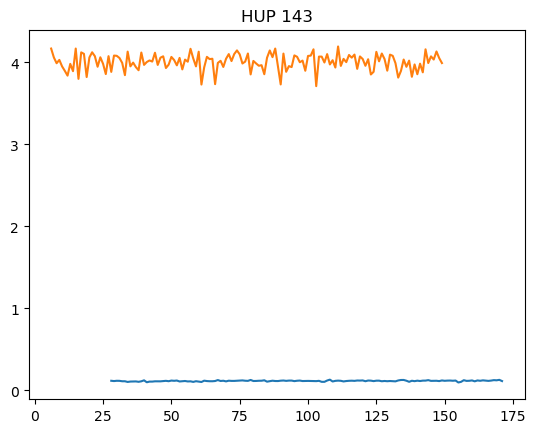

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures


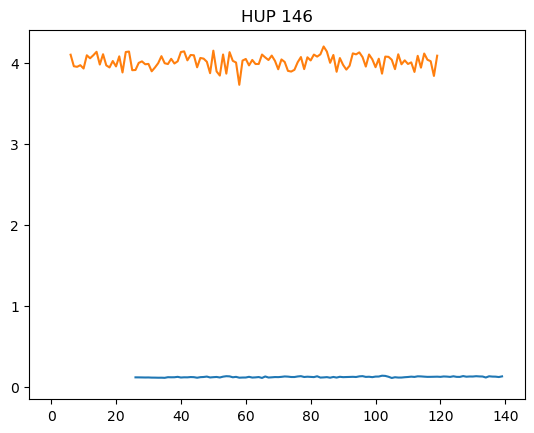

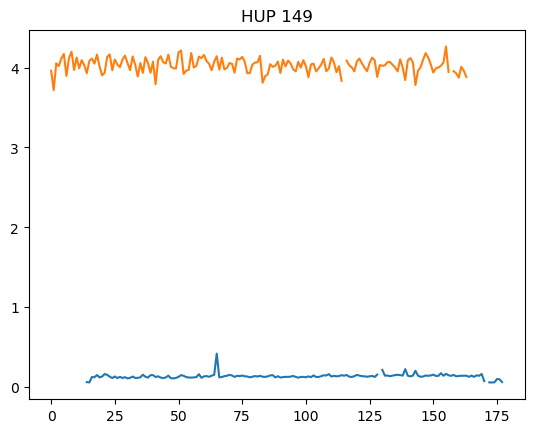

2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
File not found for HUP 153
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
File not found for HUP 157
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
1 day periods with 2 day gap contains seizures
File not found for HUP 158
File not found for HUP 165
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
File not found for HUP 169
2 day periods with 3 day gap contains seizures
2 day periods with 2 day gap contains seizures
2 day periods with 1 day gap contains seizures
File not found for HUP 171
2 day periods with 3 day gap contains s

In [27]:
for patient_hup_id in synchrony_good_hup_ids:
    # Find the ieeg_start value for patient_hup_id in ieeg_starts_df and convert it into float
    ieeg_start_hrs = float(
        ieeg_starts_df.loc[
            ieeg_starts_df["hup_id"] == patient_hup_id, "ieeg_start"
        ].values[0]
    )
    aligned_emu_start_time_hrs = round(ieeg_start_hrs)

    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    (
        before_taper_period,
        after_taper_period,
        period_length_days,
        gap_length_days,
    ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

    end_index = after_taper_period[1] - aligned_emu_start_time_hrs

    transition_period_synchrony = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
        f"kuramoto_{band}",
    ]

    try:
        transition_period_synchrony_entropy = np.load(
            os.path.join(SYNCHRONY_ENTROPY_DIRECTORY, f"HUP_{patient_hup_id}.npy")
        )
    except FileNotFoundError:
        print(f"File not found for HUP {patient_hup_id}")
        continue

    plt.plot(transition_period_synchrony)
    plt.plot(transition_period_synchrony_entropy[:end_index])
    plt.title(f"HUP {patient_hup_id}")
    plt.show()